### _Brazilian Acquirers Financial and Stock Performance vs. Macroeconomic environment_

Analyzing public traded acquirer companies.

We start by comparing their stock and financial performance against macro indexes. Then, we dive into their main financial prospects: multiples comparison, Cash Flow and Income Statement analysis and more.

This is solely a financial data analysis. No stock projection can be prospected from this study. The projection of companies' potential gains or losses take in consideration multiple factors, including: strategic and market analysis, different methods of valuation, and more.

More information on the companies studied here can be found in the links below:
- [STNE](https://investors.stone.co)
- [PAGS](https://investors.pagbank.com)
- [CIEL3](https://ri.cielo.com.br)

### Importings, Functions & Params

In [1]:
import pandas as pd 
import seaborn as sns 
import numpy as np 
import numpy_financial as npf
import datetime as dt
from datetime import datetime, timedelta
from plotly import express as px
from matplotlib import (
    dates as mdates,
    ticker,
    pyplot as plt
)

#Data Retrieving
import yfinance as yf
from bcb import sgs 

#ML
from prophet import Prophet

In [2]:
#Functions
def datetime_format(date_str_col, date_format:str=None) -> datetime:
    """
    Streamlines datetime column conversion for date manipulation. 

    :param date_str_col: pd.DataFrame or pd.Series date string-formated column
    :param date_format: date pattern to change
    """
    try:
        if (date_str_col is not None
            and ~isinstance(date_str_col, str)):
            return pd.to_datetime(date_str_col).dt.strftime(date_format)
        elif isinstance(date_str_col, datetime.timestamp):
            return dt.date(date_str_col)
        else: 
            raise ValueError("Wrong data type. Check your input.")
    except (TypeError, ValueError) as e: 
        raise ValueError(f"An error has ocurred: {e}")
    
def set_fig_context():
    """
    Streamlines figure context setting.
    """
    plt.style.use('fivethirtyeight')
    sns.set_context('paper')
    sns.set_style('whitegrid')

    plt.tight_layout()
    plt.show()
    return

def format_large_numbers(num: int | float):
    """
    Format large numbers into more readable formats.

    :param num: input number [int | float]
    """
    try:
        if  7 <= len(str(num)) < 9:
            return '{:.1f}M'.format(num/1e6)
        elif len(str(num)) >= 9 :
            return '{:.1f}B'.format(num/1e9)
        else:
            raise ValueError("Number should have a length of at least 7 characters.")
    except (TypeError, ValueError) as e:
        raise ValueError(f"An error has ocurred. Check your input: {e}")

def delta(init_val, final_val):
    delta = ((final_val - init_val)/init_val)*100 
    return delta

In [3]:
#Params
#Tickers
tickers = ["STNE", "PAGS", "CIEL3.SA"]

#Dates
start_date = datetime.date(datetime.today()) - timedelta(365*5)
base_date = start_date.strftime('%Y-%m-%d')

In [4]:
# Downloding all datasets to be used 

stne, pags, ciel3 = [],[],[] #Stock Price
stne_cf, pags_cf, ciel3_cf = [],[],[] #Cash Flow Statements [Annualized]
stne_financials, pags_financials, ciel3_financials = [],[],[] #Income Statements [Annualized]

for ticker in tickers:
    res = yf.download(ticker, start=start_date)
    res_ticker = yf.Ticker(ticker)
    
    if ticker == "STNE":
        stne.append(res)
        stne = pd.concat(stne, axis=0).reset_index()

        stne_financials.append(res_ticker.financials)
        stne_financials = pd.concat(stne_financials, axis=0).reset_index()
        
        stne_cf.append(res_ticker.cash_flow)
        stne_cf = pd.concat(stne_cf, axis=0).reset_index()
        
    elif ticker == "PAGS":
        pags.append(res)
        pags = pd.concat(pags, axis=0).reset_index()

        pags_financials.append(res_ticker.financials)
        pags_financials = pd.concat(pags_financials, axis=0).reset_index()

        pags_cf.append(res_ticker.cash_flow)
        pags_cf = pd.concat(pags_cf, axis=0).reset_index()

    elif ticker == "CIEL3.SA":
        ciel3.append(res)
        ciel3 = pd.concat(ciel3, axis=0).reset_index()

        ciel3_financials.append(res_ticker.financials)
        ciel3_financials = pd.concat(ciel3_financials, axis=0).reset_index()

        ciel3_cf.append(res_ticker.cash_flow)
        ciel3_cf = pd.concat(ciel3_cf, axis=0).reset_index()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Stock Price and Macro Analysis

In [5]:
stne.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [6]:
sets = {
        'STNE':stne, 
        'PAGS':pags, 
        'CIEL3':ciel3
        }

print("RETURNS OVERVIEW:")
for key, val in sets.items():
	init_date = val['Date'].iloc[0]
	last_date = val['Date'].iloc[-1]
	init_price = val['Close'].iloc[0]
	last_price = val['Close'].iloc[-1]

print(f"""{43*'-'}
Return for *{key}*: {delta(init_price, last_price):.2f}%
Closing price in {init_date}: {init_price:.2f},
Closing price in {last_date}: {last_price:.2f}
{43*'-'}""")

RETURNS OVERVIEW:
-------------------------------------------
Return for *CIEL3*: -57.93%
Closing price in 2019-01-21 00:00:00: 10.65,
Closing price in 2024-01-19 00:00:00: 4.48
-------------------------------------------


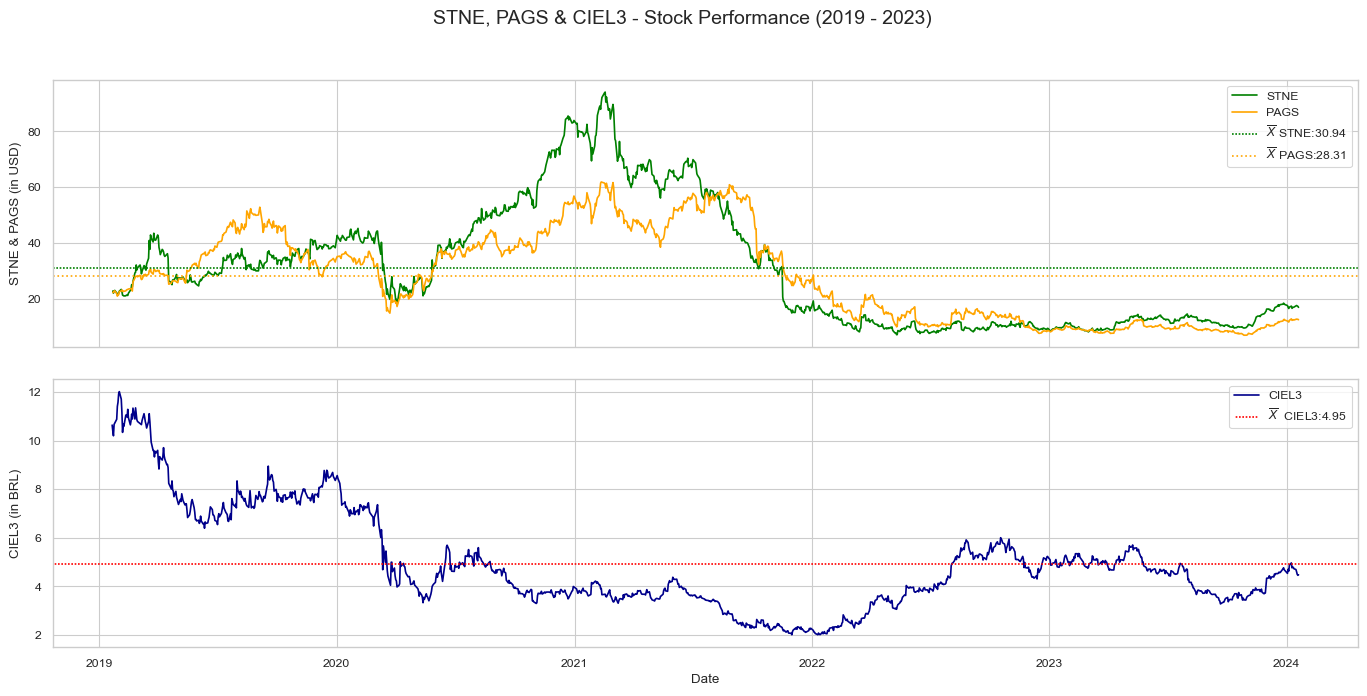

In [49]:
#Overall stocks performance over the past 4 years 
fig, (ax, ax1) = plt.subplots(nrows=2, figsize=(15,7), sharex=True)
sns.set_style('whitegrid')

sns.lineplot(data=stne, x='Date', y='Close', color='green', ax=ax, label='STNE')
sns.lineplot(data=pags, x='Date', y='Close', color='orange', ax=ax, label='PAGS')
ax.set_ylabel('STNE & PAGS (in USD)')
ax.axhline(stne['Close'].mean(), color = 'green', linestyle=(0, (1,1)), label='$\overline{X}$ STNE:' + f'{stne["Close"].mean():.2f}')
ax.axhline(pags['Close'].mean(), color = 'orange', linestyle='dotted', label='$\overline{X}$ PAGS:' + f'{pags["Close"].mean():.2f}')

plt.suptitle("STNE, PAGS & CIEL3 - Stock Performance (2019 - 2023)", size=14)

# ax1 = ax.twinx()
sns.lineplot(data=ciel3, x='Date', y='Close', color='darkblue', ax=ax1, label="CIEL3")
ax1.set_ylabel('CIEL3 (in BRL)')
ax1.axhline(ciel3['Close'].mean(), color='r', linestyle=(1, (1,1)), label="$\overline{X}$  CIEL3:" f"{ciel3['Close'].mean():.2f}")

ax.legend(loc='upper right')
ax1.legend(loc='upper right')

plt.subplots_adjust(hspace=0.12)
plt.show()

In [8]:
# Getting macroeconomic data
macro_data = sgs.get({'selic':432, 'ipca':433}, start=start_date)\
                .reset_index()\
                .rename(columns=str.upper)

macro_data.head()

,DATE,SELIC,IPCA
0,2019-01-01,NaN,0.32
1,2019-01-21,6.5,NaN
2,2019-01-22,6.5,NaN
3,2019-01-23,6.5,NaN
4,2019-01-24,6.5,NaN


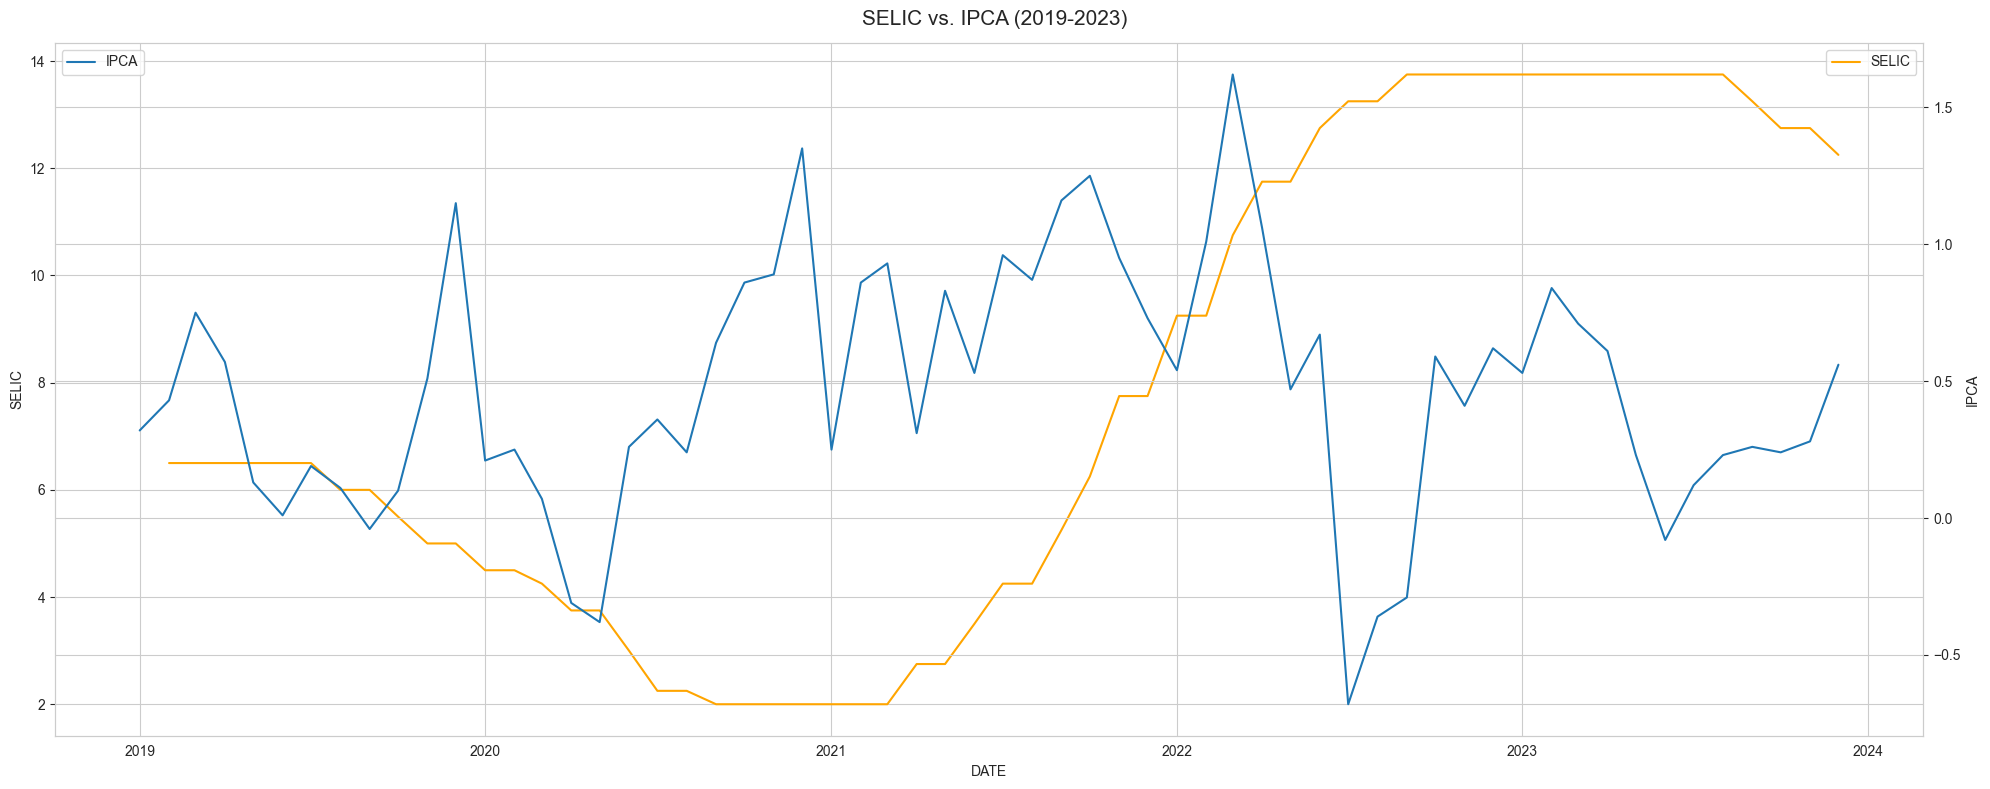

In [9]:
fig, ax = plt.subplots(figsize=(20,8))

ipca = macro_data[['DATE', 'IPCA']].dropna()
selic = macro_data[['DATE', 'SELIC']]

macro = pd.merge(ipca, selic, on='DATE', how='inner')

sns.lineplot(macro, x='DATE', y='SELIC', ax=ax, color='orange', label='SELIC')
ax1 = ax.twinx()
sns.lineplot(macro, x='DATE', y='IPCA', label='IPCA')

plt.suptitle('SELIC vs. IPCA (2019-2023)', size=15)

ax.legend(loc='upper right')
ax1.legend(loc='upper left')

plt.tight_layout()
plt.show()

### _Performing macro indexes correlation with stock performance_

For a quick reminder, Pearson's correlation can be described as follows.

\begin{equation}
r = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}
{\sqrt{\sum (x_i - \bar{x})^2 \cdot \sum (y_i - \bar{y})^2}}
\end{equation}


In [10]:
### Data preparation
%time
#Subsetting major datasets
stne_subset = stne[['Date', 'Close']].copy()
pags_subset = pags[['Date', 'Close']].copy()
ciel3_subset = ciel3[['Date', 'Close']].copy()

#Formatting date
subsets = [stne_subset, pags_subset, ciel3_subset]

for subset in subsets:
    subset['Date'] = datetime_format(subset['Date'], date_format='%Y-%b')

#Stocks unique datasets
stne_pags = pd.merge(stne_subset, pags_subset, on='Date', how='inner')
stne_pags_ciel = pd.merge(stne_pags, ciel3_subset, on='Date', how='inner')\
                    .rename(columns={
                        'Close_x':'Close_STNE',
                        'Close_y':'Close_PAGS',
                        'Close': 'Close_CIEL3'
                                    }).\
                                    sort_values(by='Date')

#Taking the mean value for each month
stne_pags_ciel = stne_pags_ciel.groupby('Date').agg('median').reset_index()
stne_pags_ciel[['Close_STNE', 'Close_PAGS', 'Close_CIEL3']] = stne_pags_ciel[['Close_STNE', 'Close_PAGS', 'Close_CIEL3']]\
                                                                .apply(lambda x: round(x, 2))

stne_pags_ciel.tail()

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


,Date,Close_STNE,Close_PAGS,Close_CIEL3
56,2023-May,13.38,11.82,5.45
57,2023-Nov,13.56,8.64,3.79
58,2023-Oct,10.01,7.80,3.52
59,2023-Sep,11.38,8.65,3.55
60,2024-Jan,17.10,12.50,4.70


In [11]:
# Now, macro
macro_data_subset = macro_data.rename(columns=str.capitalize)
macro_data_subset['Date'] = datetime_format(macro_data_subset['Date'], date_format='%Y-%b')

macro_data_subset = macro_data_subset.groupby('Date').agg('median').reset_index()

macro_data_subset.tail()

,Date,Selic,Ipca
56,2023-May,13.75,0.23
57,2023-Nov,12.25,0.28
58,2023-Oct,12.75,0.24
59,2023-Sep,13.25,0.26
60,2024-Jan,11.75,NaN


In [12]:
#Merging both sets together 

stocks_macro_index = pd.merge(stne_pags_ciel, macro_data_subset, on='Date', how='inner')
stocks_macro_index.tail()

,Date,Close_STNE,Close_PAGS,Close_CIEL3,Selic,Ipca
56,2023-May,13.38,11.82,5.45,13.75,0.23
57,2023-Nov,13.56,8.64,3.79,12.25,0.28
58,2023-Oct,10.01,7.80,3.52,12.75,0.24
59,2023-Sep,11.38,8.65,3.55,13.25,0.26
60,2024-Jan,17.10,12.50,4.70,11.75,NaN


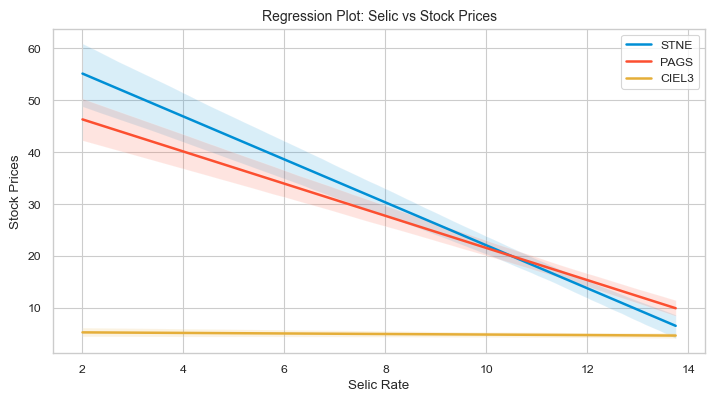

In [18]:
plt.figure(figsize=(7.5, 4))

# Plot regression plots for each stock
sns.regplot(data=stocks_macro_index, x='Selic', y='Close_STNE', label='STNE', scatter=False)
sns.regplot(data=stocks_macro_index, x='Selic', y='Close_PAGS', label='PAGS', scatter=False)
sns.regplot(data=stocks_macro_index, x='Selic', y='Close_CIEL3', label='CIEL3', scatter=False)

plt.title('Regression Plot: Selic vs Stock Prices', size=10)
plt.xlabel('Selic Rate')
plt.ylabel('Stock Prices')

plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Acquirer Stocks Price and Macro Indexes Correlation')

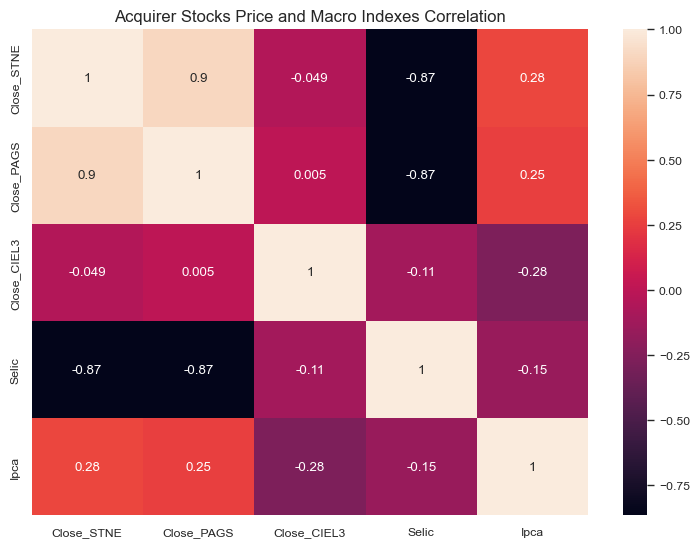

In [14]:
set_fig_context()
fig = plt.subplots(figsize=(8,6))
sns.set_context('paper')

sns.heatmap(stocks_macro_index.corr(method='pearson', numeric_only=True),
            annot=True)
plt.title("Acquirer Stocks Price and Macro Indexes Correlation", size=12)

<Figure size 640x480 with 0 Axes>

AttributeError: 'str' object has no attribute 'MaxNLocator'

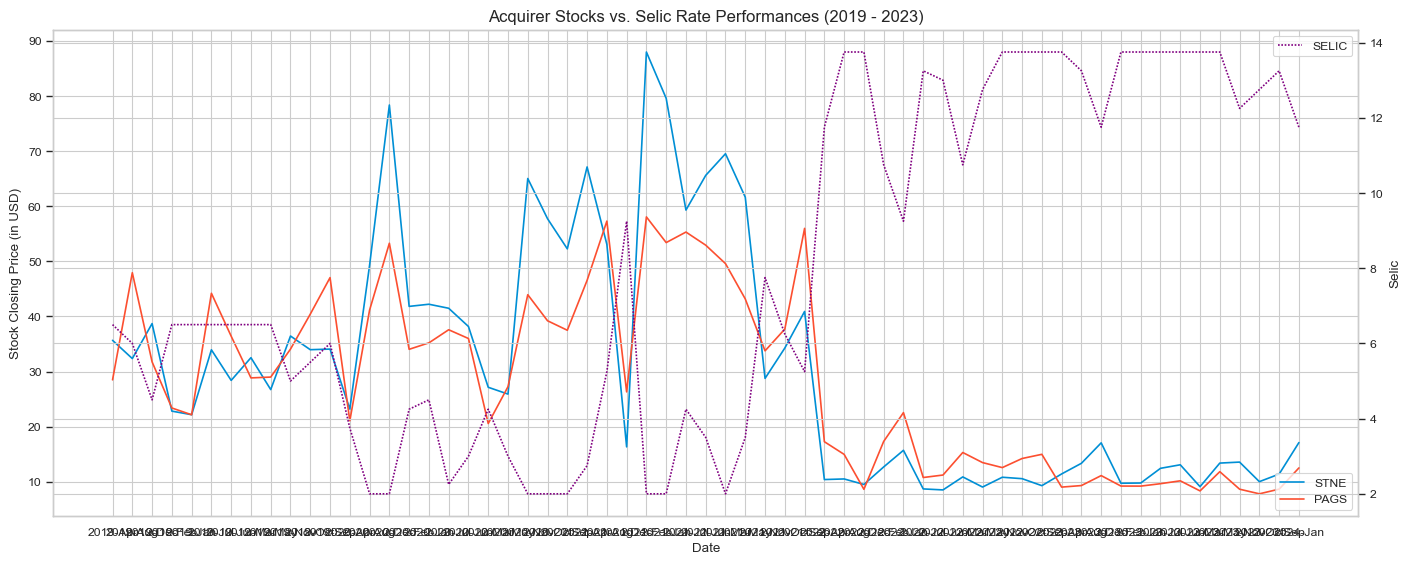

In [19]:
set_fig_context()
fig, ax = plt.subplots(figsize=(15,6))

stocks_only = stocks_macro_index[['Date', 'Close_STNE', 'Close_PAGS', 'Close_CIEL3']]
macro_only = stocks_macro_index[['Date', 'Ipca', 'Selic']]

sns.lineplot(data=stocks_only, x='Date', y='Close_STNE', ax=ax, label='STNE')
sns.lineplot(data=stocks_only, x='Date', y='Close_PAGS', ax=ax, label='PAGS')
ax.set_ylabel('Stock Closing Price (in USD)')
ax1 = ax.twinx()
sns.lineplot(data=macro_only, x='Date', y='Selic', ax=ax1, color='purple', label='SELIC', dashes=(1,1))

ax.legend(loc='lower right')
ax1.legend(loc='upper right')

plt.title("Acquirer Stocks vs. Selic Rate Performances (2019 - 2023)", size=12)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=15, integer=True))

plt.tight_layout()
plt.show()

In [ ]:
#Distribution

### Acquirers Financial Performance vs. Macro Environment

What's the macro indexes impact on Acquirer Revenue and TPV?

In [20]:
## Dataset formatting and cleaning

financial_cols_rename = {
    '2022-12-31 00:00:00': 'FY2022',
    '2021-12-31 00:00:00': 'FY2021',
    '2020-12-31 00:00:00': 'FY2020'
}

financials_datasets = [stne_financials, pags_financials, ciel3_financials, stne_cf, pags_cf, ciel3_cf]

for i, fs in list(enumerate(financials_datasets)):
    fs.rename(columns=str, inplace=True)
    fs.rename(columns=financial_cols_rename, inplace=True)

### *Forecasting*

In [21]:
ciel3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242 entries, 0 to 1241
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1242 non-null   datetime64[ns]
 1   Open       1242 non-null   float64       
 2   High       1242 non-null   float64       
 3   Low        1242 non-null   float64       
 4   Close      1242 non-null   float64       
 5   Adj Close  1242 non-null   float64       
 6   Volume     1242 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 68.0 KB


In [22]:
m = Prophet()

In [23]:
ciel3_slice = ciel3[['Date', 'Close']]

ciel3_slice.head()

,Date,Close
0,2019-01-21,10.65
1,2019-01-22,10.40
2,2019-01-23,10.21
3,2019-01-24,10.68
4,2019-01-28,10.89


In [24]:
ciel3_slice = ciel3_slice.rename(columns={'Date': 'ds', 'Close': 'y'})

ciel3_slice.head()

,ds,y
0,2019-01-21,10.65
1,2019-01-22,10.40
2,2019-01-23,10.21
3,2019-01-24,10.68
4,2019-01-28,10.89


In [25]:
m.fit(ciel3_slice)

08:30:22 - cmdstanpy - INFO - Chain [1] start processing
08:30:22 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
365/2

182.5

In [27]:
future = m.make_future_dataframe(freq='D', periods=181)

forecast = m.predict(future)

forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-21,11.272014,10.841665,11.968467,11.272014,11.272014,0.128566,0.128566,0.128566,0.140745,0.140745,0.140745,-0.012180,-0.012180,-0.012180,0.0,0.0,0.0,11.400579
1,2019-01-22,11.240860,10.803323,11.956601,11.240860,11.240860,0.134598,0.134598,0.134598,0.141932,0.141932,0.141932,-0.007334,-0.007334,-0.007334,0.0,0.0,0.0,11.375458
2,2019-01-23,11.209707,10.796042,11.899593,11.209707,11.209707,0.144236,0.144236,0.144236,0.144158,0.144158,0.144158,0.000078,0.000078,0.000078,0.0,0.0,0.0,11.353943
3,2019-01-24,11.178553,10.744221,11.916186,11.178553,11.178553,0.169159,0.169159,0.169159,0.159315,0.159315,0.159315,0.009844,0.009844,0.009844,0.0,0.0,0.0,11.347712
4,2019-01-28,11.053940,10.702380,11.831682,11.053940,11.053940,0.207919,0.207919,0.207919,0.140745,0.140745,0.140745,0.067173,0.067173,0.067173,0.0,0.0,0.0,11.261859


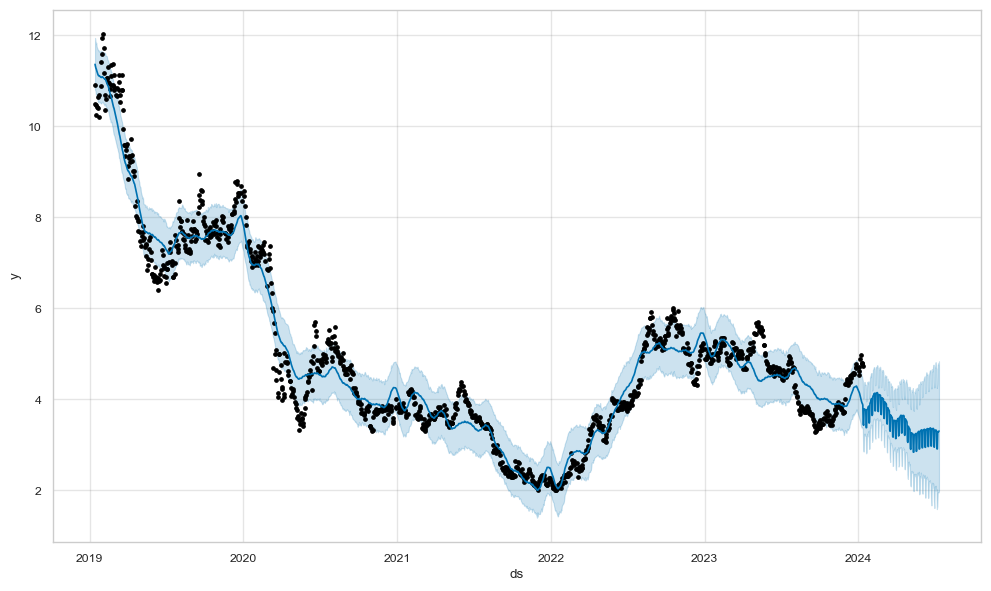

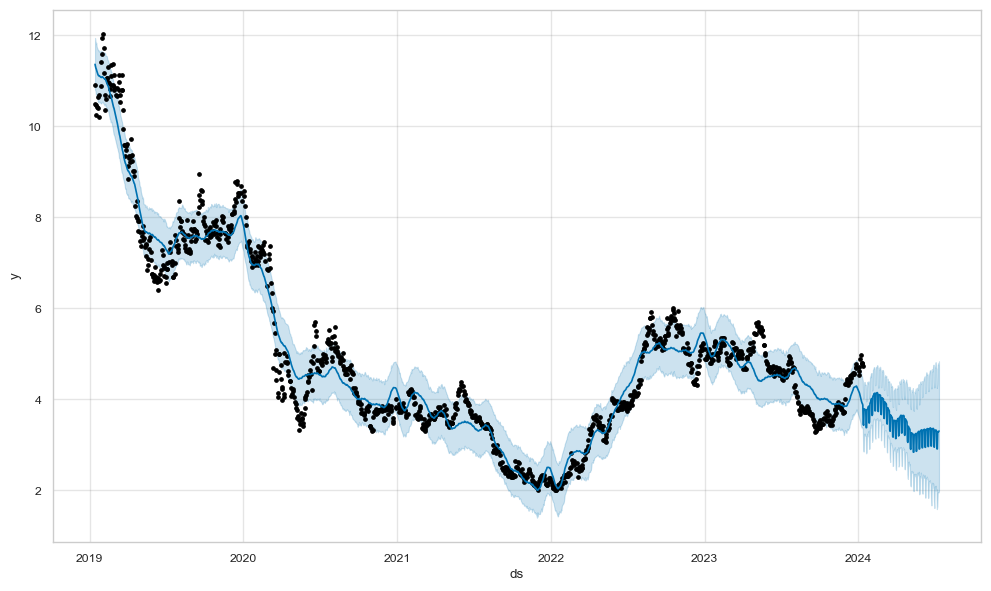

In [ ]:
m.plot(forecast)

### *Calculating WACC*

[*Weighted Average Cost of Capital*](https://www.investopedia.com/terms/w/wacc.asp).

The _Weighted Average Cost of Capital_ represents the average rate a company expects to pay to finance its business, considering all sources: preferred and common stocks, bonds, as well as other form of debts. It's an weighted average of the cost of equity, and the cost of debt after taxes. The weights are the proportion of each source of financing. It's represented as follows:

$\begin{equation}
WACC = \frac{E}{V} \cdot Re + \frac{D}{V} \cdot Rd \cdot (1 - Tc)
\end{equation}$

Where:
- $WACC$: is the Weighted Average Cost of Capital.
- $E$: is the market value of equity.
- $V$: is the total market value of equity and debt.
- $Re$: is the cost of equity.
- $D$: is the market value of debt.
- $Rd$: is the cost of debt.
- $Tc$: Tc is the corporate tax rate.

It can be calculated as follows:

```python
def wacc(cost_of_equity, market_value_of_equity, cost_of_debt, market_value_of_debt, tax_rate):
    equity_proportion = market_value_of_equity / (market_value_of_equity + market_value_of_debt)
    debt_proportion = market_value_of_debt / (market_value_of_equity + market_value_of_debt)

    wacc = equity_proportion * cost_of_equity + debt_proportion * cost_of_debt * (1 - tax_rate)
    
    return wacc
```

In [ ]:
def calculate_wacc(cost_of_equity, market_value_of_equity, cost_of_debt, market_value_of_debt, tax_rate):
    equity_proportion = market_value_of_equity / (market_value_of_equity + market_value_of_debt)
    debt_proportion = market_value_of_debt / (market_value_of_equity + market_value_of_debt)

    wacc = equity_proportion * cost_of_equity + debt_proportion * cost_of_debt * (1 - tax_rate)
    
    return wacc

# Example usage
wacc_vars = {
    'cost_of_equity' : 0.08,  # Placeholder values, replace with actual values
    'market_value_of_equity' : 1000000,
    'cost_of_debt' : 0.05,
    'market_value_of_debt' : 500000,
    'tax_rate' : 0.3
            }

result_wacc = calculate_wacc(**wacc_vars)
print(f"WACC: {result_wacc:.4f}")

WACC: 0.0650
